# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall22/week02-convnets/cifar.py

--2023-02-03 17:19:34--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall22/week02-convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2023-02-03 17:19:34 (12.8 MB/s) - ‘cifar.py’ saved [2396/2396]



In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


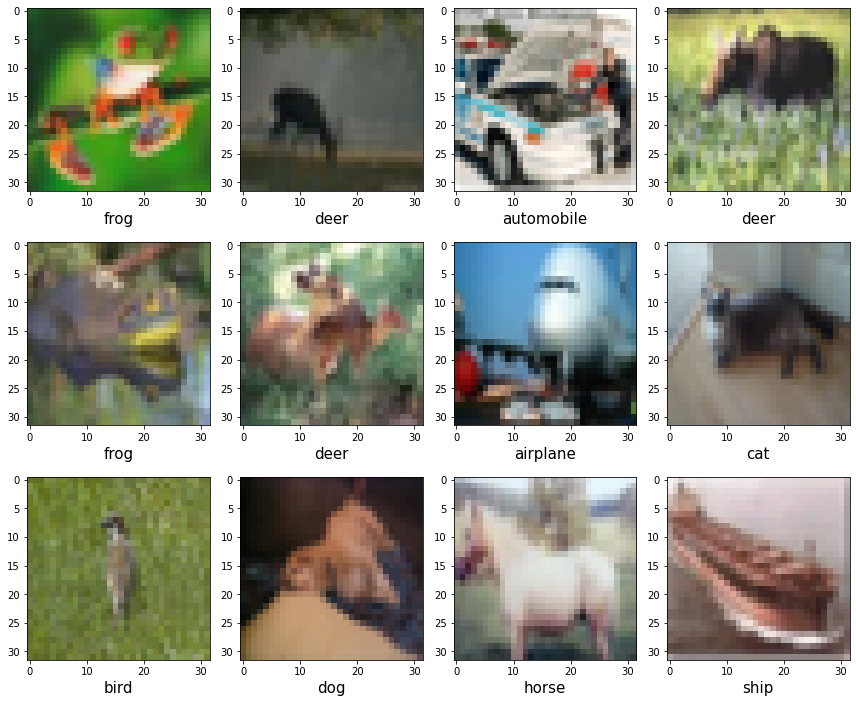

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]], size = 15)
    plt.imshow(np.transpose(X_train[i],[1,2,0]))
plt.tight_layout()

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [15]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense_1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense_1_relu', nn.ReLU())
model.add_module('dense_2_logits', nn.Linear(64, 10)) # logits for 10 classes
model.to(device)

Sequential(
  (flatten): Flatten()
  (dense_1): Linear(in_features=3072, out_features=64, bias=True)
  (dense_1_relu): ReLU()
  (dense_2_logits): Linear(in_features=64, out_features=10, bias=True)
)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [16]:
print(type(X_train), type(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [19]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch.to(device)).cpu()
    return F.cross_entropy(logits, y_batch).mean()

In [20]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3764, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [21]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [22]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [24]:
### looking at model output
for X_batch, y_batch in iterate_minibatches(X_train, y_train, 4):
    with torch.no_grad():
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).cpu()
    break
print("logits shape: ", logits.shape)
print("max: ", logits.max(1))
print("max[1]: ", logits.max(1)[1].data.numpy())
print("y: ", y_batch)

logits shape:  torch.Size([4, 10])
max:  torch.return_types.max(
values=tensor([0.2840, 0.1586, 0.1511, 0.1998]),
indices=tensor([8, 8, 8, 8]))
max[1]:  [8 8 8 8]
y:  [1 6 9 0]


In [26]:
import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 64  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).cpu()
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 20 took 0.881s
  training loss (in-iteration): 	1.883142
  validation accuracy: 			35.77 %
Epoch 2 of 20 took 0.881s
  training loss (in-iteration): 	1.820595
  validation accuracy: 			37.40 %
Epoch 3 of 20 took 0.879s
  training loss (in-iteration): 	1.774852
  validation accuracy: 			36.68 %
Epoch 4 of 20 took 0.875s
  training loss (in-iteration): 	1.740085
  validation accuracy: 			39.96 %
Epoch 5 of 20 took 0.871s
  training loss (in-iteration): 	1.706680
  validation accuracy: 			38.99 %
Epoch 6 of 20 took 0.874s
  training loss (in-iteration): 	1.679586
  validation accuracy: 			42.29 %
Epoch 7 of 20 took 0.868s
  training loss (in-iteration): 	1.651733
  validation accuracy: 			42.29 %
Epoch 8 of 20 took 0.869s
  training loss (in-iteration): 	1.629574
  validation accuracy: 			43.63 %
Epoch 9 of 20 took 0.868s
  training loss (in-iteration): 	1.606705
  validation accuracy: 			43.81 %
Epoch 10 of 20 took 0.926s
  training loss (in-iteration): 	1.590141
  validation 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [27]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).cpu()
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		46.74 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [28]:
conv_model = nn.Sequential()
conv_model.add_module("conv_1", nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
conv_model.add_module("relu_1", nn.ReLU())
conv_model.add_module("pool_1", nn.MaxPool2d(2))
conv_model.add_module("flatten", Flatten())
conv_model.add_module("dense_1", nn.Linear(10*15*15, 100))
conv_model.add_module("relu_2", nn.ReLU())#
conv_model.add_module("dropout", nn.Dropout(0.10))
conv_model.add_module("dense_2", nn.Linear(100, 10))
conv_model.to(device)
opt = torch.optim.Adam(conv_model.parameters())

In [29]:
def compute_loss(model, X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch.to(device)).cpu()
    return F.cross_entropy(logits, y_batch).mean()

In [35]:
def train_model(model, opt, num_epochs):
    
    train_loss = []
    val_accuracy = []
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            # train on batch
            loss = compute_loss(model, X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.numpy())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).cpu()
            y_pred = logits.max(1)[1].data.numpy()
            val_accuracy.append(np.mean(y_batch == y_pred))


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
        
def final_test(model):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device)).cpu()
        y_pred = logits.max(1)[1].data.numpy()
        test_batch_acc.append(np.mean(y_batch == y_pred))

    test_accuracy = np.mean(test_batch_acc)

    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

In [36]:
train_model(conv_model, opt, 20)

Epoch 1 of 20 took 1.393s
  training loss (in-iteration): 	1.517929
  validation accuracy: 			47.97 %
Epoch 2 of 20 took 1.385s
  training loss (in-iteration): 	1.392570
  validation accuracy: 			53.57 %
Epoch 3 of 20 took 1.396s
  training loss (in-iteration): 	1.319596
  validation accuracy: 			54.41 %
Epoch 4 of 20 took 1.575s
  training loss (in-iteration): 	1.275634
  validation accuracy: 			56.07 %
Epoch 5 of 20 took 1.468s
  training loss (in-iteration): 	1.226297
  validation accuracy: 			55.53 %
Epoch 6 of 20 took 1.422s
  training loss (in-iteration): 	1.189266
  validation accuracy: 			57.83 %
Epoch 7 of 20 took 1.404s
  training loss (in-iteration): 	1.151666
  validation accuracy: 			58.20 %
Epoch 8 of 20 took 1.421s
  training loss (in-iteration): 	1.124009
  validation accuracy: 			58.08 %
Epoch 9 of 20 took 1.400s
  training loss (in-iteration): 	1.091577
  validation accuracy: 			58.63 %
Epoch 10 of 20 took 1.408s
  training loss (in-iteration): 	1.068762
  validation 

In [37]:
final_test(conv_model)

Final results:
  test accuracy:		59.64 %


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [38]:
conv_bn_model = nn.Sequential()
conv_bn_model.add_module("conv_1", nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
conv_bn_model.add_module("batch_norm_1", nn.BatchNorm2d(10))
conv_bn_model.add_module("relu_1", nn.ReLU())
conv_bn_model.add_module("pool_1", nn.MaxPool2d(2))
conv_bn_model.add_module("flatten", Flatten())
conv_bn_model.add_module("dense_1", nn.Linear(10*15*15, 100))
conv_bn_model.add_module("batch_norm_2", nn.BatchNorm1d(100))
conv_bn_model.add_module("relu_2", nn.ReLU())#
conv_bn_model.add_module("dropout", nn.Dropout(0.10))
conv_bn_model.add_module("dense_2", nn.Linear(100, 10))
conv_bn_model.to(device)
opt = torch.optim.Adam(conv_bn_model.parameters())

In [39]:
train_model(conv_bn_model, opt, 20)

Epoch 1 of 20 took 1.839s
  training loss (in-iteration): 	1.391323
  validation accuracy: 			57.50 %
Epoch 2 of 20 took 1.756s
  training loss (in-iteration): 	1.095485
  validation accuracy: 			54.08 %
Epoch 3 of 20 took 1.715s
  training loss (in-iteration): 	0.968494
  validation accuracy: 			62.02 %
Epoch 4 of 20 took 1.755s
  training loss (in-iteration): 	0.882236
  validation accuracy: 			60.79 %
Epoch 5 of 20 took 1.773s
  training loss (in-iteration): 	0.812709
  validation accuracy: 			62.94 %
Epoch 6 of 20 took 1.911s
  training loss (in-iteration): 	0.744429
  validation accuracy: 			61.71 %
Epoch 7 of 20 took 1.713s
  training loss (in-iteration): 	0.691699
  validation accuracy: 			63.10 %
Epoch 8 of 20 took 1.742s
  training loss (in-iteration): 	0.638996
  validation accuracy: 			62.64 %
Epoch 9 of 20 took 1.735s
  training loss (in-iteration): 	0.592624
  validation accuracy: 			63.29 %
Epoch 10 of 20 took 2.012s
  training loss (in-iteration): 	0.553671
  validation 

In [40]:
final_test(conv_bn_model)

Final results:
  test accuracy:		61.81 %



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [65]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-5, 5]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [66]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)
test_loader = CIFAR10("./cifar_data/", train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(means, stds)]))

batch_size = 32

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=1)

In [57]:
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

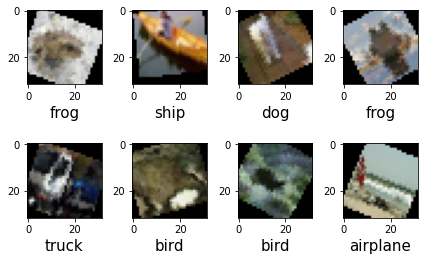

In [67]:
for i, img in enumerate(x.numpy()[:8]):
    plt.subplot(2, 4, i+1)
    plt.imshow(img.transpose([1,2,0]) * stds + means )
    plt.xlabel(class_names[y[i]], size = 15)
plt.tight_layout()

In [151]:
def train_model_use_dataloader(model, opt, num_epochs):
    
    train_loss = []
    val_accuracy = []
    max_accuracy = -1
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for (x_batch, y_batch) in train_batch_gen:
            # train on batch
            logits = model(x_batch.to(device)).cpu()
            loss = F.cross_entropy(logits, y_batch).mean()
            #torch.autograd.set_detect_anomaly(True)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.numpy())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for x_batch, y_batch in test_batch_gen:
            logits = model(x_batch.to(device)).cpu()
            y_pred = logits.max(1)[1]
            val_accuracy.append(np.mean(y_batch.data.numpy() == y_pred.data.numpy()))

        temp_accuracy = np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100
        if temp_accuracy > max_accuracy:
            best_model_state = model.state_dict()
            max_accuracy = temp_accuracy
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
    return best_model_state



def test_model(model):
    model.train(False) # disable dropout / use averages for batch_norm
    for x_batch, y_batch in test_batch_gen:
        logits = model(x_batch.to(device)).cpu()
        y_pred = logits.max(1)[1]
        val_accuracy.append(np.mean(y_batch.data.numpy() == y_pred.data.numpy()))

    accuracy = np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100
    print(f"best model accuracy: {accuracy:.2f}")
    
    
def class_accuracy(model):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
         for images, labels in test_batch_gen:
            outputs = model(images.to(device)).cpu()
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of {} : {:.2f} %'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))

for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
    #raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

In [102]:
conv_bn_model = nn.Sequential()
conv_bn_model.add_module("conv_1", nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
conv_bn_model.add_module("batch_norm_1", nn.BatchNorm2d(10))
conv_bn_model.add_module("relu_1", nn.ReLU())
conv_bn_model.add_module("pool_1", nn.MaxPool2d(2))
conv_bn_model.add_module("flatten", Flatten())
conv_bn_model.add_module("dense_1", nn.Linear(10*15*15, 100))
conv_bn_model.add_module("batch_norm_2", nn.BatchNorm1d(100))
conv_bn_model.add_module("relu_2", nn.ReLU())#
conv_bn_model.add_module("dropout", nn.Dropout(0.10))
conv_bn_model.add_module("dense_2", nn.Linear(100, 10))
conv_bn_model.to(device)
opt = torch.optim.Adam(conv_bn_model.parameters())

In [103]:
best_conv_bn_model_state = train_model_use_dataloader(conv_bn_model, opt, 20)

Epoch 1 of 20 took 36.786s
  training loss (in-iteration): 	1.516977
  validation accuracy: 			53.71 %
Epoch 2 of 20 took 36.216s
  training loss (in-iteration): 	1.389864
  validation accuracy: 			57.51 %
Epoch 3 of 20 took 36.116s
  training loss (in-iteration): 	1.343602
  validation accuracy: 			59.24 %
Epoch 4 of 20 took 36.667s
  training loss (in-iteration): 	1.302371
  validation accuracy: 			60.72 %
Epoch 5 of 20 took 37.374s
  training loss (in-iteration): 	1.279457
  validation accuracy: 			62.11 %
Epoch 6 of 20 took 36.874s
  training loss (in-iteration): 	1.258271
  validation accuracy: 			62.75 %
Epoch 7 of 20 took 36.777s
  training loss (in-iteration): 	1.240389
  validation accuracy: 			63.36 %
Epoch 8 of 20 took 36.103s
  training loss (in-iteration): 	1.227653
  validation accuracy: 			63.18 %
Epoch 9 of 20 took 34.902s
  training loss (in-iteration): 	1.212244
  validation accuracy: 			64.73 %
Epoch 10 of 20 took 34.500s
  training loss (in-iteration): 	1.201984
  v

In [104]:
conv_bn_model_best = nn.Sequential()
conv_bn_model_best.add_module("conv_1", nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
conv_bn_model_best.add_module("batch_norm_1", nn.BatchNorm2d(10))
conv_bn_model_best.add_module("relu_1", nn.ReLU())
conv_bn_model_best.add_module("pool_1", nn.MaxPool2d(2))
conv_bn_model_best.add_module("flatten", Flatten())
conv_bn_model_best.add_module("dense_1", nn.Linear(10*15*15, 100))
conv_bn_model_best.add_module("batch_norm_2", nn.BatchNorm1d(100))
conv_bn_model_best.add_module("relu_2", nn.ReLU())#
conv_bn_model_best.add_module("dropout", nn.Dropout(0.10))
conv_bn_model_best.add_module("dense_2", nn.Linear(100, 10))
conv_bn_model_best.to(device)

Sequential(
  (conv_1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm_1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (dense_1): Linear(in_features=2250, out_features=100, bias=True)
  (batch_norm_2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (dense_2): Linear(in_features=100, out_features=10, bias=True)
)

In [113]:
conv_bn_model_best.load_state_dict(best_conv_bn_model_state)
test_model(conv_bn_model_best)
class_accuracy(conv_bn_model_best)

best model accuracy: 67.15
Accuracy of plane : 79.65 %
Accuracy of car : 86.09 %
Accuracy of bird : 46.05 %
Accuracy of cat : 44.19 %
Accuracy of deer : 59.09 %
Accuracy of dog : 62.83 %
Accuracy of frog : 79.34 %
Accuracy of horse : 78.12 %
Accuracy of ship : 83.19 %
Accuracy of truck : 74.26 %


When testing, we don't need random crops, just normalize with same statistics.

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = <YOUR CODE>

# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


In [ ]:
# you might as well write your solution here :)

#### VGG

In [114]:
def vgg_block(in_channels, out_channels, num_convs=2):
    block = nn.Sequential()
    for i in range(num_convs):
        if i==0:
            block.add_module(f"conv_{i}", nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding = 1))
        else:
            block.add_module(f"conv_{i}", nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding = 1))
        block.add_module(f"batch_norm_{i}", nn.BatchNorm2d(out_channels))
        block.add_module(f"relu{i}", nn.ReLU())
        
    block.add_module("pooling", nn.MaxPool2d(2))
    return block


class VGG(nn.Module):
    def __init__(self, n_layers=5):
        super().__init__()
        self.n_layers = n_layers
        self.layers = nn.Sequential()
        self.params = ((3, 64, 2), (64, 128, 2), (128, 256, 3), (256, 512, 3), (512, 512, 3))
        
        for i in range(self.n_layers):
            in_channels, out_channels, num_convs = self.params[i]
            self.layers.add_module(f"layer_{i}", vgg_block(in_channels, out_channels, num_convs))
        
        self.layers.add_module("flatten", Flatten())
        self.fc = nn.Linear(512, 10)
        self.layers.add_module("fc", self.fc)
        
    def forward(self, x):
        batch_size = x.shape[0]
        for layer in self.layers:
            x = layer.forward(x)
            
        return x

In [115]:
vgg = VGG().to(device)
opt = torch.optim.Adam(vgg.parameters())
best_vgg_state = train_model_use_dataloader(vgg, opt, 20)

Epoch 1 of 20 took 48.705s
  training loss (in-iteration): 	1.677758
  validation accuracy: 			41.57 %
Epoch 2 of 20 took 46.461s
  training loss (in-iteration): 	1.205439
  validation accuracy: 			60.01 %
Epoch 3 of 20 took 46.259s
  training loss (in-iteration): 	0.974002
  validation accuracy: 			68.62 %
Epoch 4 of 20 took 48.162s
  training loss (in-iteration): 	0.831645
  validation accuracy: 			73.47 %
Epoch 5 of 20 took 47.003s
  training loss (in-iteration): 	0.726061
  validation accuracy: 			78.30 %
Epoch 6 of 20 took 47.467s
  training loss (in-iteration): 	0.641664
  validation accuracy: 			78.23 %
Epoch 7 of 20 took 47.739s
  training loss (in-iteration): 	0.586256
  validation accuracy: 			80.84 %
Epoch 8 of 20 took 46.508s
  training loss (in-iteration): 	0.530523
  validation accuracy: 			84.38 %
Epoch 9 of 20 took 46.401s
  training loss (in-iteration): 	0.489125
  validation accuracy: 			84.57 %
Epoch 10 of 20 took 47.115s
  training loss (in-iteration): 	0.450474
  v

In [117]:
best_vgg = VGG().to(device)
best_vgg.load_state_dict(best_vgg_state)
test_model(best_vgg)
class_accuracy(best_vgg)

best model accuracy: 88.89
Accuracy of plane : 85.84 %
Accuracy of car : 95.65 %
Accuracy of bird : 83.55 %
Accuracy of cat : 79.07 %
Accuracy of deer : 87.12 %
Accuracy of dog : 84.96 %
Accuracy of frog : 95.87 %
Accuracy of horse : 89.84 %
Accuracy of ship : 95.58 %
Accuracy of truck : 93.38 %


In [152]:
def get_conv(kernel_size, in_features, out_features, with_bn=True, with_relu=True):
    """Create conv -> [relu] -> [bn] layers, embedded in torch.nn.Sequential module.
    
    ! Conv layer must preserve spatial tensor dims (i.e. apply zero padding).
    
    Args:
        kernel_size: int
        in_features: int
        out_features: int
        with_bn: bool
        with_relu: bool
        
    Returns:
        torch.nn.Sequential
    """
    layers = [
        # nn.Conv2d(... # YOUR CODE HERE
        nn.Conv2d(in_features, out_features, kernel_size, 1, kernel_size // 2)
    ]
    
    if with_relu:
        # YOUR CODE HERE
        layers.append(nn.ReLU(inplace=(with_bn is True)))
        
    if with_bn:
        # YOUR CODE HERE
        layers.append(nn.BatchNorm2d(out_features))
    
    return nn.Sequential(*layers)
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, with_bn=True):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        
        if out_channels != in_channels:
            self.projection = nn.Conv2d(in_channels, out_channels, 1, 1, 0)
        else:
            self.projection = None
            
        layers = []
        
        for _ in range(num_layers):
            layers.append(conv_layer(3, in_channels, out_channels))
            in_channels = out_channels
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        output = self.layers.forward(x)
        
        if self.projection:
            output += self.projection(x)
            
        else:
            output += x
        
        return output
        

class GlobalAveragePool(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        
        return torch.mean(x, dim = (2, 3))
    
    
def create_resnet34():
    pool = nn.MaxPool2d(2)
    gap = GlobalAveragePool()
    fc = nn.Linear(512, 10)
    
    layers = [conv_layer(7, 3, 64), pool]   
    for _ in range(3):
        layers.append(ResidualBlock(64, 64, 2))
    
    layers.append(pool)
    layers.append(ResidualBlock(64, 128, 2))
    for _ in range(3):
        layers.append(ResidualBlock(128, 128, 2))
    
    layers.append(pool)    
    layers.append(ResidualBlock(128, 256, 2))
    for _ in range(4):
        layers.append(ResidualBlock(256, 256, 2))
    
    layers.append(pool)
    layers.append(ResidualBlock(256, 512, 2))
    for _ in range(3):
        layers.append(ResidualBlock(512, 512, 2))
        
    layers.append(pool)
    layers.append(Flatten())
    layers.append(fc)
    return nn.Sequential(*layers)

In [153]:
resnet_34 = create_resnet34()
resnet_34.to(device)
resnet_34(torch.rand((32, 3, 32, 32)).to(device)).shape

torch.Size([32, 10])

In [154]:
resnet_34 = create_resnet34().to(device)
opt = torch.optim.Adam(resnet_34.parameters())
best_resnet_34 = train_model_use_dataloader(resnet_34, opt, 20)

Epoch 1 of 20 took 160.490s
  training loss (in-iteration): 	1.680984
  validation accuracy: 			50.16 %
Epoch 2 of 20 took 161.065s
  training loss (in-iteration): 	1.345192
  validation accuracy: 			56.29 %
Epoch 3 of 20 took 160.343s
  training loss (in-iteration): 	1.203035
  validation accuracy: 			62.87 %
Epoch 4 of 20 took 161.078s
  training loss (in-iteration): 	1.108371
  validation accuracy: 			65.22 %
Epoch 5 of 20 took 161.115s
  training loss (in-iteration): 	1.032043
  validation accuracy: 			67.33 %
Epoch 6 of 20 took 161.156s
  training loss (in-iteration): 	0.968737
  validation accuracy: 			68.84 %
Epoch 7 of 20 took 161.994s
  training loss (in-iteration): 	0.920108
  validation accuracy: 			71.50 %
Epoch 8 of 20 took 161.827s
  training loss (in-iteration): 	0.885656
  validation accuracy: 			71.82 %
Epoch 9 of 20 took 161.017s
  training loss (in-iteration): 	0.859070
  validation accuracy: 			73.97 %
Epoch 10 of 20 took 160.910s
  training loss (in-iteration): 	0.

In [155]:
resnet_34 = create_resnet34().to(device)
resnet_34.load_state_dict(best_resnet_34)
test_model(resnet_34)
class_accuracy(resnet_34)

best model accuracy: 78.88
Accuracy of plane : 87.61 %
Accuracy of car : 90.43 %
Accuracy of bird : 68.42 %
Accuracy of cat : 67.44 %
Accuracy of deer : 80.30 %
Accuracy of dog : 61.06 %
Accuracy of frog : 79.34 %
Accuracy of horse : 82.81 %
Accuracy of ship : 86.73 %
Accuracy of truck : 88.97 %
